In [4]:
!pip install transformers datasets pandas


In [9]:
from transformers import AutoModelForCausalLM, AutoTokenizer, Trainer, TrainingArguments
import pandas as pd
from datasets import Dataset
import os

os.environ['HF_TOKEN'] = 'your_huggingface_token_here'

model_name = "gpt2"
model = AutoModelForCausalLM.from_pretrained(model_name, token=os.environ['HF_TOKEN'])
tokenizer = AutoTokenizer.from_pretrained(model_name, token=os.environ['HF_TOKEN'])

tokenizer.pad_token = tokenizer.eos_token

df = pd.read_csv('/content/impression_300_llm.csv')
dataset = Dataset.from_pandas(df)

def tokenize_function(examples):
    inputs = tokenizer(examples['Report Name'], examples['History'], examples['Observation'], truncation=True, padding=True)
    inputs['labels'] = inputs['input_ids'].copy()
    return inputs

tokenized_dataset = dataset.map(tokenize_function, batched=True)

training_args = TrainingArguments(
    output_dir='./results',
    per_device_train_batch_size=8,
    num_train_epochs=3
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset.train_test_split(test_size=30)['train'],
    eval_dataset=tokenized_dataset.train_test_split(test_size=30)['test']
)

trainer.train()

model.save_pretrained("./fine-tuned-model")


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Map:   0%|          | 0/330 [00:00<?, ? examples/s]

Step,Training Loss


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


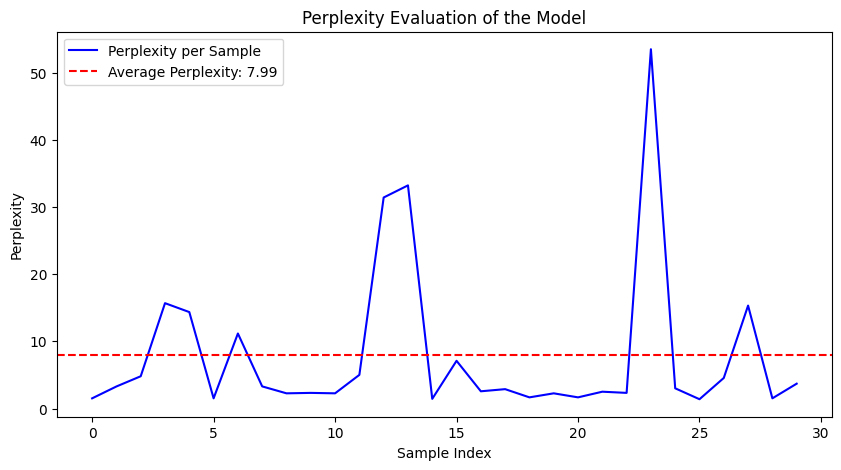

The model 'GPT2LMHeadModel' is not supported for text-classification. Supported models are ['AlbertForSequenceClassification', 'BartForSequenceClassification', 'BertForSequenceClassification', 'BigBirdForSequenceClassification', 'BigBirdPegasusForSequenceClassification', 'BioGptForSequenceClassification', 'BloomForSequenceClassification', 'CamembertForSequenceClassification', 'CanineForSequenceClassification', 'LlamaForSequenceClassification', 'ConvBertForSequenceClassification', 'CTRLForSequenceClassification', 'Data2VecTextForSequenceClassification', 'DebertaForSequenceClassification', 'DebertaV2ForSequenceClassification', 'DistilBertForSequenceClassification', 'ElectraForSequenceClassification', 'ErnieForSequenceClassification', 'ErnieMForSequenceClassification', 'EsmForSequenceClassification', 'FalconForSequenceClassification', 'FlaubertForSequenceClassification', 'FNetForSequenceClassification', 'FunnelForSequenceClassification', 'GemmaForSequenceClassification', 'Gemma2ForSequenc

In [16]:
from transformers import AutoModelForCausalLM, AutoTokenizer, Trainer, TrainingArguments
import pandas as pd
from datasets import Dataset
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
from sklearn.metrics.pairwise import cosine_similarity
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
import nltk

nltk.download('stopwords')
nltk.download('wordnet')

model = AutoModelForCausalLM.from_pretrained("./fine-tuned-model")
tokenizer = AutoTokenizer.from_pretrained(model_name)

def calculate_perplexity(text):
    tokenizer.pad_token = tokenizer.eos_token
    inputs = tokenizer(text, return_tensors='pt', padding='longest', truncation=True)
    with torch.no_grad():
        outputs = model(**inputs, labels=inputs['input_ids'])
        log_likelihood = outputs.loss.item()
    perplexity = np.exp(log_likelihood)
    return perplexity


perplexities = []
eval_texts = tokenized_dataset.train_test_split(test_size=30)['test']['Report Name']

for text in eval_texts:
    perplexity = calculate_perplexity(text)
    perplexities.append(perplexity)

average_perplexity = np.mean(perplexities)

plt.figure(figsize=(10, 5))
plt.plot(perplexities, label='Perplexity per Sample', color='blue')
plt.axhline(y=average_perplexity, color='red', linestyle='--', label=f'Average Perplexity: {average_perplexity:.2f}')
plt.title('Perplexity Evaluation of the Model')
plt.xlabel('Sample Index')
plt.ylabel('Perplexity')
plt.legend()
plt.show()

text_analysis_pipeline = pipeline("text-classification", model=model, tokenizer=tokenizer)

sample_texts = eval_texts[:5]
# for text in sample_texts:
#     try:
#         analysis = text_analysis_pipeline(text)
#         print(f'Text: {text}\nAnalysis: {analysis}\n')
#     except Exception as e:
        # print(f'Error analyzing text: {text}\nError: {str(e)}\n')



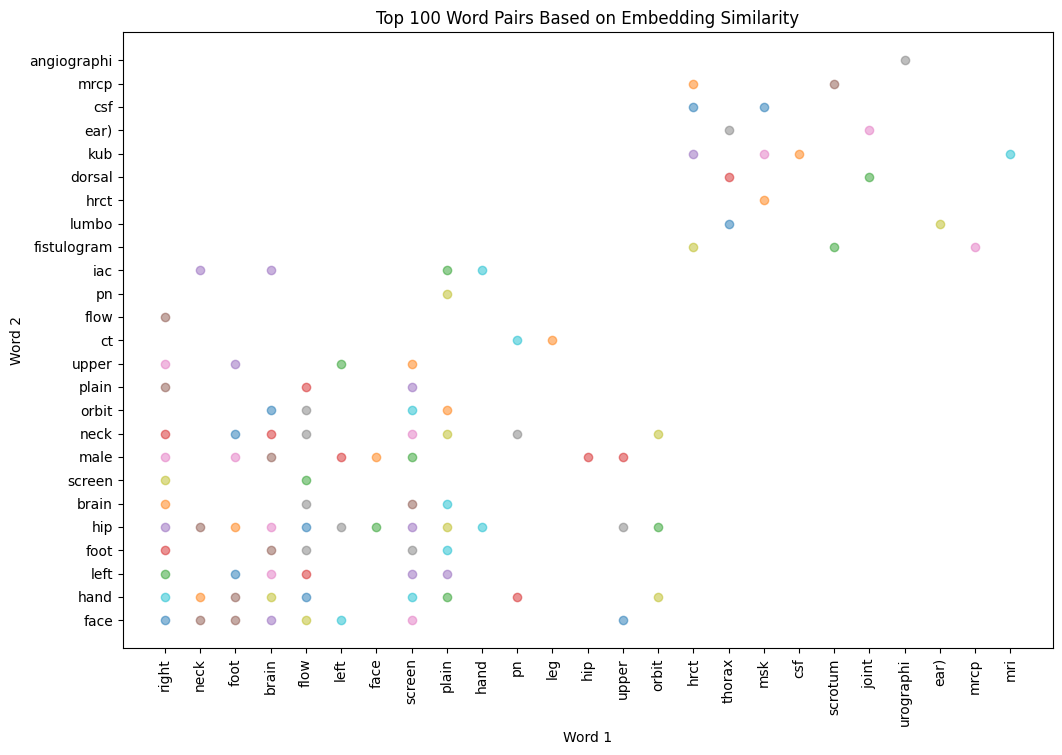

In [19]:
def preprocess_text(text):
    if not isinstance(text, str) or not text.strip():
        return []
    stop_words = set(stopwords.words('english'))
    stemmer = PorterStemmer()
    lemmatizer = WordNetLemmatizer()
    words = text.split()
    words = [lemmatizer.lemmatize(stemmer.stem(word.lower())) for word in words if word.lower() not in stop_words]
    return words

all_words = []
for text in df['Report Name']:
    processed = preprocess_text(text)
    all_words.extend(processed)

if all_words:
    unique_words = list(set(all_words))
else:
    unique_words = []

if unique_words:
    word_embeddings = []
    for word in unique_words:
        inputs = tokenizer(word, return_tensors='pt')
        with torch.no_grad():
            outputs = model(**inputs)
            # Get the hidden states or the logits from the last layer
            embeddings = outputs.logits.mean(dim=1).squeeze().numpy()  # Squeeze to flatten
        word_embeddings.append((word, embeddings))

    word_embeddings = np.array([embed for _, embed in word_embeddings])
    similarity_matrix = cosine_similarity(word_embeddings)
    word_pairs = []

    for i in range(len(unique_words)):
        for j in range(i + 1, len(unique_words)):
            word_pairs.append((unique_words[i], unique_words[j], similarity_matrix[i][j]))

    word_pairs.sort(key=lambda x: x[2], reverse=True)
    top_100_pairs = word_pairs[:100]

    plt.figure(figsize=(12, 8))
    for pair in top_100_pairs:
        plt.scatter(pair[0], pair[1], alpha=0.5)
    plt.title('Top 100 Word Pairs Based on Embedding Similarity')
    plt.xlabel('Word 1')
    plt.ylabel('Word 2')
    plt.xticks(rotation=90)
    plt.show()
else:
    print("No unique words found.")

# New Section